# SVHN from Scratch using TensorFlow

The goal of this notebook is to take what I've learned from the [Udacity Deep Learning course](https://www.udacity.com/course/deep-learning--ud730) and apply it to training an algorithm that can perform image to text translation on the [Stanford Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/), successfully recognizing street address numbers in real-world images.

Because I've recently gotten very excited about LSTMs, I'll be attempting to complete this task by connecting the output of a convolutional net to an RNN decoder.

In [52]:
import os
import sys
import numpy
import scipy.io
import gzip
import tarfile
import h5py
from PIL import Image
import six.moves.cPickle as pickle
from six.moves import urllib
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

Many thanks to Imad Ali who gave a [great example](https://github.com/imadmali/svhn-format1) of how to preprocess this dataset using Python's `h5py` library. The next few cells are adapted from his work.

In [5]:
data_dir = '../data'

# Download the SVHN dataset if it is not present
def check_dataset(dataset):
    # Check if dataset is in the data directory.
    new_path = os.path.join(data_dir, dataset)
    if (not os.path.isdir(data_dir)):
        os.mkdir(data_dir)
    if (not os.path.isfile(new_path)):
        origin = ('http://ufldl.stanford.edu/housenumbers/' + dataset)
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, new_path)
    return new_path

train_dataset = check_dataset('train.tar.gz')
test_dataset = check_dataset('test.tar.gz')

In [40]:
def format_data(dataset):
    print '... processing data (should only occur when downloading for the first time)'
    # Unzip data from scratch
    data_type = os.path.splitext(os.path.splitext(dataset)[0])[0]
    unzipped_path = os.path.join(data_dir, data_type)
    if os.path.exists(unzipped_path):
        shutil.rmtree(unzipped_path)
    tar = tarfile.open(os.path.join(data_dir, dataset), 'r:gz')
    tar.extractall(data_dir)

    # Access label information in digitStruct.mat
    f = h5py.File(os.path.join(data_dir, data_type, 'digitStruct.mat'), 'r')
    digit_struct_name = f['digitStruct']['name']
    digit_struct_bbox = f['digitStruct']['bbox']

    def getName(n):
        return ''.join([chr(c[0]) for c in f[digit_struct_name[n][0]].value])

    def bboxHelper(attr):
        if (len(attr) > 1):
            attr = [f[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(n):
        bbox = {}
        bb = digit_struct_bbox[n].item()
        bbox['height'] = bboxHelper(f[bb]["height"])
        bbox['label'] = bboxHelper(f[bb]["label"])
        bbox['left'] = bboxHelper(f[bb]["left"])
        bbox['top'] = bboxHelper(f[bb]["top"])
        bbox['width'] = bboxHelper(f[bb]["width"])
        return bbox

    # Process bbox
    print '... creating image box bound dict for %s data' % data_type
    image_dict = {}
    for i in range(len(digit_struct_name)):
        image_dict[getName(i)] = getBbox(i)
        if (i % 2000 == 0):
            print '\timage dict processing: %i/%i complete' %(i, len(digit_struct_name))
    print '... dict processing complete'

    # Process the data
    print('... processing image data and labels')
    names = [item for item in os.listdir(unzipped_path) if item.endswith('.png')]

    x, y = [], []
    for i in range(len(names)):
        y.append(image_dict[names[i]]['label'])
        image = Image.open(unzipped_path + '/' + names[i])
        # Calculate the total bounding box from the exterior corners of all bounding boxes
        left = int(min(image_dict[names[i]]['left']))
        upper = int(min(image_dict[names[i]]['top']))
        right = int(max(image_dict[names[i]]['left'])) + int(max(image_dict[names[i]]['width']))
        lower = int(max(image_dict[names[i]]['top'])) + int(max(image_dict[names[i]]['height']))
        image = image.crop(box = (left, upper, right, lower))
        image = image.resize([32,32])
        image_array = numpy.array(image)
        # Normalize mean and standard deviation
        image_array = (image_array - 255. / 2) / 255.
        x.append(image_array)
        if (i % 2000 == 0):
            print '\timage processing: %i/%i complete' %(i,len(names))
    print '... image processing complete'

    # Save data
    print '... pickling data'
    out = {'labels': y, 'images': x}
    out_path = os.path.join(data_dir, data_type + 'pkl.gz')
    p = gzip.open(out_path, 'wb')
    pickle.dump(out, p)
    p.close()

    tar.close()
    
    # clean up (delete test/train folders that were used to create the pickled data)
    shutil.rmtree(unzipped_path)

Only format the data if the processed pickle files don't exist.

In [44]:
if (not os.path.isfile(os.path.join(data_dir, 'trainpkl.gz'))):
    format_data('train.tar.gz')

f_train = gzip.open(os.path.join(data_dir, 'trainpkl.gz'), 'rb')
train_data = pickle.load(f_train)
f_train.close()

if (not os.path.isfile(os.path.join(data_dir, 'testpkl.gz'))):
    format_data('test.tar.gz')

f_test = gzip.open(os.path.join(data_dir, 'testpkl.gz'), 'rb')
test_data = pickle.load(f_test)
f_test.close()

In [45]:
# Convert data format
def convert_data_format(data):
    images = data.pop('images')
    images = numpy.array(images)
    images = numpy.rollaxis(images, 0, 4)
    X = numpy.reshape(images,
                      (numpy.prod(images.shape[:-1]), images.shape[-1]),
                      order='C').T

    labels = data.pop('labels')
    for i in range(len(labels)):
        l = len(labels[i])-1
        zeros = numpy.zeros(6-l-1).tolist()
        labels[i].extend(zeros)
    y = numpy.array(labels)
    
    return (X,y)

train_set = convert_data_format(train_data)
train_set_len = len(train_set[1])

# Extract validation dataset from train dataset (10% of the train_set)
valid_set = [x[-(train_set_len//10):] for x in train_set]
train_set = [x[:-(train_set_len//10)] for x in train_set]
test_set = convert_data_format(test_data)

`train_set`, `valid_set`, and `test_set` each contain a list `['flattened image', 'label']`.
* `'flattened image'` is a 2D numpy array where each row corresponds to a 32x32x3 image.
* `'label'` is a 2D numpy array where each row is a house number and each element of that row is a digit. The rows are
  padded at a length of 6 digits where the number `0` represents the padding, and the number `10` represents the
  digit `0`.

As a sanity check, let's display an image from the test set. The image will look odd because of the mean and standard deviation normalization we did in the `format_data()` method.

[  2.  10.  10.   0.   0.   0.]


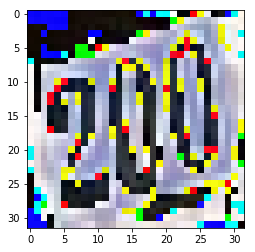

In [57]:
data_index = 994
img = numpy.reshape(test_set[0][data_index], (32,32,3))
plt.imshow(img)
print(test_set[1][data_index])